# Study of correlation between number of Cities and Airports in the US
### Data Engineering Capstone Project

#### Project Summary
This project summarizes the number of cities and number of airports in each state in the US, and analyzes the correlation between them

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import psycopg2
import csv


In [2]:
def create_database():
    # connect to default database
    conn = psycopg2.connect("host=127.0.0.1 dbname=studentdb user=student password=student")
    conn.set_session(autocommit=True)
    cur = conn.cursor()
    
    # create sparkify database with UTF8 encoding
    cur.execute("DROP DATABASE IF EXISTS sparkifydb")
    cur.execute("CREATE DATABASE sparkifydb WITH ENCODING 'utf8' TEMPLATE template0")

    # close connection to default database
    conn.close()    
    
    # connect to sparkify database
    conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
    cur = conn.cursor()
    
    return cur, conn

In [3]:
cur, conn = create_database()


### Step 1: Scope the Project and Gather Data

#### Scope 
This project uses the US-Cities-demography data, as well as the  airport-codes_csv data. 

#### Describe and Gather Data 
The US-Cities-demography data contains the city, state and population information of each city.
The airport-codes_csv data contains airport location information for many airports in the US and some parts of the world.

In [4]:
# Read in the data here
df_demography=pd.read_csv('us-cities-demographics.csv',sep=';')
df_airport=pd.read_csv('airport-codes_csv.csv')


### Step 2: Explore and Assess the Data
#### Explore the Data 
The airport data contains iso-region column. It contains state info. In order to extract the state info from this column, we need to perform several steps.
#### Cleaning Steps
1. filter US only airports
2. extract state_code from  iso-region
3. ingest the data from  csv to database  tables

In [5]:

#filter US only airports
df_airport = df_airport[df_airport['iso_country']=='US']


#extract state_code
a=df_airport['iso_region']
b=a.str.slice(3,5)
df_airport_cleansed=df_airport
df_airport_cleansed['state_code']=b
df_airport_cleansed.to_csv (r'airport_data_cleansed.csv', index = False, header=True)

In [6]:
#create demography table
demography_table_create = ("""CREATE TABLE IF NOT EXISTS demography(\
    city text NOT NULL, \
    state text,\
    median_age text,\
    male_population text,\
    female_population text,\
    total_population text,\
    num_veterans text,\
    foreign_born text,\
    ave_household_size text,\
    state_code text,\
    race text,\
    count text,\
    PRIMARY KEY (city))
""")
cur.execute ( "DROP TABLE IF EXISTS demography")
cur.execute(demography_table_create)
conn.commit()

In [7]:
#ingest data from  csv  to database

import csv
csv.register_dialect('unixpwd', delimiter=';', quoting=csv.QUOTE_NONE)
#with open('passwd', newline='') as f:
#    reader = csv.reader(f, 'unixpwd')


with open('us-cities-demographics.csv', 'r') as f:
    reader = csv.reader(f,'unixpwd')
    next(reader) # Skip the header row.
    for row in reader:
        cur.execute(
        "INSERT INTO demography VALUES (%s, %s, %s, %s,%s, %s, %s, %s,%s, %s, %s, %s) ON CONFLICT (city) \
        DO NOTHING",
        row
        )
conn.commit()

In [8]:
# create database table
airport_table_create = ("""CREATE TABLE IF NOT EXISTS airport(\
    ident text, \
    type text,\
    name text,\
    elevation_ft text,\
    continent text,\
    iso_country text,\
    iso_region text,\
    municipality text,\
    gps_code text,\
    iata_code text, \
    local_code text,\
    coorinates text,\
    state_code text,\
    PRIMARY KEY (name))
""")
cur.execute ("DROP TABLE IF EXISTS airport")
cur.execute(airport_table_create)
#conn.commit()

In [9]:
#ingest data from  csv  to database
import csv
import psycopg2

with open('airport_data_cleansed.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader) # Skip the header row.
    for row in reader:
        cur.execute(
        "INSERT INTO airport VALUES (%s, %s, %s, %s,%s, %s, %s, %s,%s, %s, %s, %s, %s) ON CONFLICT (name) \
        DO NOTHING",
        row
        )
conn.commit()

In [11]:
#test data ingestion is correct for demography table
# print("Table: demography\n")
# try: 
#     cur.execute("SELECT * FROM demography;")
# except psycopg2.Error as e: 
#     print("Error: select *")
#     print (e)

# row = cur.fetchone()
# while row:
#    print(row)
#    row = cur.fetchone()

In [40]:
#test data ingestion is correct for airport table
# print("Table: airport\n")
# try: 
#     cur.execute("SELECT * FROM airport;")
# except psycopg2.Error as e: 
#     print("Error: select *")
#     print (e)

# row = cur.fetchone()
# while row:
#    print(row)
#    row = cur.fetchone()

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Here we want to first count the number of cities in  a state, count the number of airports in a state, then, tabulate them side by side.
#### 3.2 Mapping Out Data Pipelines
1. Count (cities) group by State
2. Count (airports) group by State
3. Merge dataframes by state
4. Plot Count (cities) and Count (airports) side by side

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [22]:
# count(city) by state
num_city_by_state= pd.DataFrame(columns=['city_count','state'])

try:
     cur.execute("SELECT COUNT(city),state_code FROM demography GROUP BY state_code;")
except psycopg2.Error as e: 
     print("Error: select *")
     print (e)
row = cur.fetchone()

while row:
    num_city_by_state=num_city_by_state.append(pd.Series(row, index=['city_count','state']),ignore_index=True)
    row = cur.fetchone()
num_city_by_state


city_count state
0           7    PA
1          15    AZ
2          47    FL
3           8    LA
4           2    MT
5           4    NM
6           1    AK
7          12    NC
8           7    OR
9           1    MS
10          6    AR
11         19    IL
12          6    MO
13          9    IN
14          1    HI
15         10    UT
16         16    MI
17          7    KS
18         10    MD
19         10    GA
20         10    MN
21          1    DC
22          9    WI
23          2    NE
24         10    OH
25          7    CT
26          9    NV
27          7    PR
28          6    OK
29          7    AL
30        133    CA
31         15    CO
32          2    ND
33         17    WA
34          2    KY
35          1    ME
36          4    RI
37         12    VA
38          9    TN
39          2    SD
40          2    NH
41          7    IA
42          4    SC
43          9    NY
44         12    MA
45         12    NJ
46         55    TX
47          3    ID

In [29]:
#count(airport) by state
num_airport_by_state= pd.DataFrame(columns=['airport_count','state'])

try:
    cur.execute("SELECT COUNT(name),state_code FROM airport GROUP BY state_code;")
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)
row = cur.fetchone()
while row:
    print (row)
    num_airport_by_state=num_airport_by_state.append(pd.Series(row, index=['airport_count','state']),ignore_index=True)
    row = cur.fetchone()
#num_airport_by_state

(869, 'PA')
(347, 'AZ')
(929, 'FL')
(10, 'U-')
(570, 'LA')
(295, 'MT')
(189, 'NM')
(801, 'AK')
(439, 'NC')
(453, 'OR')
(94, 'VT')
(256, 'MS')
(384, 'AR')
(838, 'IL')
(523, 'MO')
(64, 'HI')
(628, 'IN')
(115, 'WY')
(159, 'UT')
(517, 'MI')
(403, 'KS')
(237, 'MD')
(483, 'GA')
(525, 'MN')
(580, 'WI')
(20, 'DC')
(732, 'OH')
(285, 'NE')
(157, 'CT')
(145, 'NV')
(496, 'OK')
(341, 'AL')
(1045, 'CA')
(479, 'CO')
(123, 'WV')
(301, 'ND')
(55, 'DE')
(239, 'KY')
(536, 'WA')
(194, 'ME')
(35, 'RI')
(195, 'SD')
(317, 'TN')
(459, 'VA')
(167, 'NH')
(313, 'IA')
(197, 'SC')
(627, 'NY')
(241, 'MA')
(298, 'ID')
(427, 'NJ')
(2113, 'TX')


In [30]:
print (num_city_by_state.shape)
print (num_airport_by_state.shape)

(48, 2)
(52, 2)


In [31]:
df_merged=pd.merge(num_city_by_state, num_airport_by_state, on='state')

In [37]:
#sort by city count
result = df_merged.sort_values(by=['city_count'])

In [38]:
result

city_count state airport_count
34          1    ME           194
6           1    AK           801
21          1    DC            20
9           1    MS           256
14          1    HI            64
23          2    NE           285
39          2    NH           167
38          2    SD           195
4           2    MT           295
33          2    KY           239
31          2    ND           301
46          3    ID           298
41          4    SC           197
35          4    RI            35
5           4    NM           189
12          6    MO           523
10          6    AR           384
27          6    OK           496
40          7    IA           313
28          7    AL           341
25          7    CT           157
0           7    PA           869
8           7    OR           453
17          7    KS           403
3           8    LA           570
42          9    NY           627
13          9    IN           628
37          9    TN           317
22          9    WI           580
26          9    NV           145
20         10    MN           525
19         10    GA           483
18         10    MD           237
15         10    UT           159
24         10    OH           732
7          12    NC           439
36         12    VA           459
44         12    NJ           427
43         12    MA           241
30         15    CO           479
1          15    AZ           347
16         16    MI           517
32         17    WA           536
11         19    IL           838
2          47    FL           929
45         55    TX          2113
29        133    CA          1045

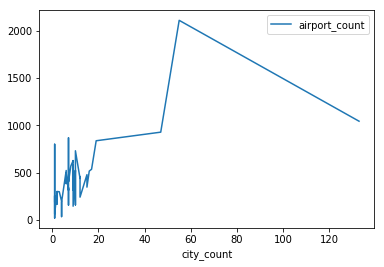

In [39]:
result.plot(x='city_count',y='airport_count')

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., city name and airport name as the  unique keys)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness


In [41]:
# Perform quality checks here
print (result.shape)
print (num_city_by_state.shape)
print (num_airport_by_state.shape)



(47, 3)
(48, 2)
(52, 2)


After the merge, 47 states are common across city and airport tables

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

This table - 'result'  has only 3 columns:
* city_count: number of cities in a state
* airport_count: number of airports in a state
* state:state code

The table sorted by city_count in ascending order

#### Step 5: Complete Project Write Up
* This project uses Postgresql, since it is a structured dataset
* the data is not expected to be updated often given it's about city and airport locations. 
* If the database needs to be access by 100+ people, I would host the data on a cloud data warehouse, and give public access to all, since it does not contain  any proprietary info at all 